References from this notebook:
https://colab.research.google.com/drive/1JMLa53HDuA-i7ZBmqV7ZnA3c_fvtXnx-?usp=sharing

#### 데이터 로드 및 확인

In [2]:
# read it in to inspect it
with open('input.txt', 'r', encoding='utf-8') as f:
    text = f.read()
print("length of dataset in characters: ", len(text))

length of dataset in characters:  1115394


In [3]:
# let's look at the first 1000 characters
print(text[:50])

First Citizen:
Before we proceed any further, hear


#### 전체 문자 개수 확인 및 문자-인덱스 매핑 딕셔너리 구축

In [4]:
# here are all the unique characters that occur in this text
chars = sorted(list(set(text)))
vocab_size = len(chars)
print(''.join(chars))
print(vocab_size)


 !$&',-.3:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz
65


In [5]:
stoi = { ch:i for i,ch in enumerate(chars) }
itos = { i:ch for i,ch in enumerate(chars) }
encode = lambda s: [stoi[c] for c in s] # encoder: take a string, output a list of integers
decode = lambda l: ''.join([itos[i] for i in l]) # decoder: take a list of integers, output a string

print(encode("hii there"))
print(decode(encode("hii there")))

# 텐서로 변환
import torch 
data = torch.tensor(encode(text), dtype=torch.long)
print(data.shape, data.dtype)
print(data[:50]) 

[46, 47, 47, 1, 58, 46, 43, 56, 43]
hii there
torch.Size([1115394]) torch.int64
tensor([18, 47, 56, 57, 58,  1, 15, 47, 58, 47, 64, 43, 52, 10,  0, 14, 43, 44,
        53, 56, 43,  1, 61, 43,  1, 54, 56, 53, 41, 43, 43, 42,  1, 39, 52, 63,
         1, 44, 59, 56, 58, 46, 43, 56,  6,  1, 46, 43, 39, 56])


#### 트레이닝 & validation set 분할

In [6]:
n = int(0.9*len(data))
train_data = data[:n]
val_data = data[n:]

#### 블록 사이즈 결정 (블록 사이즈 = 예측에 쓰이는 maximum context의 길이)

In [7]:
block_size = 8
train_data[:block_size+1]

tensor([18, 47, 56, 57, 58,  1, 15, 47, 58])

In [8]:
x = train_data[:block_size] 
y = train_data[1:block_size+1]

for t in range(block_size):
    context = x[:t+1] # cotext의 길이를 하나씩 늘리되, block size까지
    target = y[t] # context 마지막의 바로 다음 토큰
    print(f"when input is {context} the target: {target}")

when input is tensor([18]) the target: 47
when input is tensor([18, 47]) the target: 56
when input is tensor([18, 47, 56]) the target: 57
when input is tensor([18, 47, 56, 57]) the target: 58
when input is tensor([18, 47, 56, 57, 58]) the target: 1
when input is tensor([18, 47, 56, 57, 58,  1]) the target: 15
when input is tensor([18, 47, 56, 57, 58,  1, 15]) the target: 47
when input is tensor([18, 47, 56, 57, 58,  1, 15, 47]) the target: 58


#### 배치 사이즈와 블록 사이즈에 따라, 배치 데이터 로드 (get_batch) => 트랜스포머에 들어갈 인풋 정의

In [9]:
torch.manual_seed(1337)
batch_size = 4 # 병렬로 처리되는 시퀀스의 수 (how many independent sequences will we process in parallel?)
block_size = 8 # 예측에 쓰이는 maxmium context 길이(what is the maximum context length for predictions?)

# generate a small batch of data of inputs x and targets y
def get_batch(split):
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,)) # 시작 시점부터 block_size 뒤까지 읽어야 하니 len(data)-block_size에서 randint를 뽑음
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    return x, y

xb, yb = get_batch('train') # 트레인 데이터셋에서, 각 batch_size(4)개의 시작 시점에서 block_size(8)만큼의 문맥을 읽어 쌓아 올림
print('inputs:')
print(xb.shape)
print(xb)

print('targets:')
print(yb.shape)
print(yb)
print('----')

for b in range(batch_size): # 각 배치 내 시퀀스에 대해,
    for t in range(block_size): # 각 시퀀스 내 컨텍스트의 시점을 바꾸어 가며,
        context = xb[b, :t+1] # b번째 배치의 t+1 시점까지의 컨텍스트 (즉 1, 2, 3,  .., block_size 까지)
        target = yb[b,t] # b번째 배치의 타겟 
        print(f"when input is {context.tolist()} the target: {target}")

inputs:
torch.Size([4, 8])
tensor([[24, 43, 58,  5, 57,  1, 46, 43],
        [44, 53, 56,  1, 58, 46, 39, 58],
        [52, 58,  1, 58, 46, 39, 58,  1],
        [25, 17, 27, 10,  0, 21,  1, 54]])
targets:
torch.Size([4, 8])
tensor([[43, 58,  5, 57,  1, 46, 43, 39],
        [53, 56,  1, 58, 46, 39, 58,  1],
        [58,  1, 58, 46, 39, 58,  1, 46],
        [17, 27, 10,  0, 21,  1, 54, 39]])
----
when input is [24] the target: 43
when input is [24, 43] the target: 58
when input is [24, 43, 58] the target: 5
when input is [24, 43, 58, 5] the target: 57
when input is [24, 43, 58, 5, 57] the target: 1
when input is [24, 43, 58, 5, 57, 1] the target: 46
when input is [24, 43, 58, 5, 57, 1, 46] the target: 43
when input is [24, 43, 58, 5, 57, 1, 46, 43] the target: 39
when input is [44] the target: 53
when input is [44, 53] the target: 56
when input is [44, 53, 56] the target: 1
when input is [44, 53, 56, 1] the target: 58
when input is [44, 53, 56, 1, 58] the target: 46
when input is [44, 53

In [10]:
# 트랜스포머에 들어갈 인풋
print(xb) # our input to the transformer

tensor([[24, 43, 58,  5, 57,  1, 46, 43],
        [44, 53, 56,  1, 58, 46, 39, 58],
        [52, 58,  1, 58, 46, 39, 58,  1],
        [25, 17, 27, 10,  0, 21,  1, 54]])


#### Bi-gram Language Model 클래스 정의

In [24]:
import torch
import torch.nn as nn
from torch.nn import functional as F
torch.manual_seed(1337)

vocab_size = 65

# Q. 클래스 이름이 bigram langauge model인 이유?
# Q. token_embedding_table의 의미? 65*65 행렬로 만드는 이유? vocab size*embedding size 인건가?

class BigramLanguageModel(nn.Module): # 

    def __init__(self, vocab_size):
        super().__init__()
        self.token_embedding_table = nn.Embedding(vocab_size, vocab_size) # vocab_size * vocab_size

    # Q. forward의 의미? 하나의 토큰(단어)을 이용해 다음 토큰(단어)를 예측했을 때의 차이값을 계산?
    def forward(self, idx, targets=None):
        # idx, targets: 둘 다 B*T 행렬
        # idx를 token_embedding_table을 이용해 logits인 B*T*C 행렬로 변환 (targets는 B*T 행렬)
        logits = self.token_embedding_table(idx) # (B,T,C) = (batch size * block size * vocab size)

        if targets is None: # targets가 있는 경우 예측값과 정답 간 로스를 계산 / 없는 경우는 예측값만 반환
            loss = None

        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C) # logits를 (B*T, C) 행렬로 변환 -> next sentence에 대한 확률이라고 생각함
            targets = targets.view(B*T) # targets를 B*T 행렬로 변환
            loss = F.cross_entropy(logits, targets) # logits와 targets 사이의 크로스 엔트로피 로스 계산
        return logits, loss

    # 텍스트 생성 과정: idx (현재 문맥에서의 (B, T) 크기 행렬)을 집어넣었을 때 나오는 행렬
    def generate(self, idx, max_new_tokens): 
       #  idx: [[0]] (배치 1개) B*T 행렬
        for _ in range(max_new_tokens):
            logits, loss = self(idx) # foward 호출 (idx에 대해, 각 vocab이 나올 확률 도출) -> logits: B*T*C=1*T*65 행렬, loss = None / T는 1부터 100까지 늘어남 (idx 가 for 문 순회할수록 늘어남)
            logits = logits[:, -1, :] # becomes (B, C) # 마지막 시점의 결과값에만 집중 -> logits: B*C 행렬
            probs = F.softmax(logits, dim=-1) # (B, C) # 마지막 시점의 결과값을 확률값으로 변환하기 위해 softmax 사용 -> logits: B*C 행렬
            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1) # 확률값에 따른 샘플링 (다양한 결과를 생성하기 위해) -> logits: B*1 행렬 (C의 확률값에 따른 샘플링)
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1) # 현재까지 결과(B*T)에 이번에 나온 결과(B*1)를 갖다붙여서 다음 idx에 사용
        
        return idx

m = BigramLanguageModel(vocab_size) # vocab_size = 65

# xb: 4*8, yb: 4*8 (batch size * block size)
logits, loss = m(xb, yb) 
print(logits.shape) # (4*8, 65)
print(loss)

generate_result = m.generate(idx = torch.zeros((4, 1), dtype=torch.long), max_new_tokens=100)
for i in range(4):
    result = generate_result[i].tolist() # [[0]] 을 input으로 generate에 넣었을 때, 생성된 결과
    print(decode(result))

# result = m.generate(idx = torch.zeros((1, 1), dtype=torch.long), max_new_tokens=100)[0].tolist() # [[0]] 을 input으로 generate에 넣었을 때, 생성된 결과
# print(decode(result))

torch.Size([32, 65])
tensor(4.8786, grad_fn=<NllLossBackward0>)

Sr?qP-QWktXoL&jLDJgOLVz'RIoDqHdhsV&vLLxatjscMpwLERSPyao.qfzs$Ys$zF-w,;eEkzxjgCKFChs!iWW.ObzDnxA Ms$3

S
vviYDEsxyfqoioCp$NzbjuG&v&LWSbJ;hi?Lb$QY&ss;A'X3hiTOpTE;hJ?;phsZAUt$HZZ;ABjjup'Q&tRl,f.SPyhJFbZM?G

,OMkDCV&oj$-UybS
wfq-waeOvERmsEP f;H;-wvhs:CKSjHddZvEH-lH-Z?gFdfL& CWdzLERSGJkYKo-oimb?ERjulgC-m
pwJ

&Q:EJh$fRFuXuErIdbRmYhcmztgTEXWtlwa&Zy'P?a!PGLKIJoX:P N-w.oCKzPgOrUMkqUGAVOVE,'QKugXIfB!-gZ3cOdmnlIh


In [17]:
import torch
import torch.nn.functional as F

def cross_entropy_loss(logits, targets):
    probabilities = F.softmax(logits, dim=1) # 로짓에 소프트맥스 적용하여 확률 계산
    log_probabilities = torch.log(probabilities) # 정답 레이블에 해당하는 로그 확률 선택
    print(log_probabilities.shape)
    print(log_probabilities[0][59])
    print(log_probabilities[1][6])
    selected_log_probs = log_probabilities[range(log_probabilities.shape[0]), targets]

    print(selected_log_probs)
    loss = -selected_log_probs.mean()
    return loss

# logits = torch.tensor([[2.0, 1.0, 0.1], [1.0, 3.0, 0.1]], requires_grad=True)
# targets = torch.tensor([0, 1])
#cross_entropy_loss(logits, targets)
cross_entropy_loss(logits, yb.view(32))

torch.Size([32, 65])
tensor(-7.1094, grad_fn=<SelectBackward0>)
tensor(-4.5905, grad_fn=<SelectBackward0>)
tensor([-5.4015, -3.5575, -5.1182, -4.9321, -4.4768, -6.6375, -4.9009, -3.6508,
        -5.2996, -5.2699, -4.3121, -5.3172, -4.1158, -3.8830, -3.7805, -5.3198,
        -5.9110, -5.3198, -5.3172, -4.1158, -3.8830, -3.7805, -5.3198, -6.6375,
        -5.4962, -5.5252, -3.9628, -6.1686, -4.3907, -5.7943, -4.0775, -4.4435],
       grad_fn=<IndexBackward0>)


tensor(4.8786, grad_fn=<NegBackward0>)

In [18]:
# create a PyTorch optimizer
optimizer = torch.optim.AdamW(m.parameters(), lr=1e-3)

In [19]:
# block_size = 8 # 예측에 쓰이는 maxmium context 길이(what is the maximum context length for predictions?)

def get_batch(split):
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,)) # 시작 시점부터 block_size 뒤까지 읽어야 하니 len(data)-block_size에서 randint를 뽑음
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    return x, y

batch_size = 32
for steps in range(100): # increase number of steps for good results...
    xb, yb = get_batch('train') # B*T = 32*8
    logits, loss = m(xb, yb) # evaluate the loss
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()
print(loss.item())

4.530343055725098


In [20]:
print(decode(m.generate(idx = torch.zeros((1, 1), dtype=torch.long), max_new_tokens=500)[0].tolist()))


SpWWAfCAuCX:bOlgiRQWN:Mphaw
tRLKuYXEaAXxrcq-gCUzeh3w!AcyaylgYWjmJM?Uzw:inaY,:C&OECW:vmGGJAn3onAuMgia!ms$Vb q-gCOcPcUhOnxJGUGSPJWT:.?ujmJFoiNL&A'DxY,prZ?qdT;hoo'dHooXXlxf'WkHK&u3Q?rqUi.kz;?Yx?C&u3Qbfzxlyh'Vl:zyxjKXgC?
lv'QKFiBeviNxO'm!Upm$srm&TqViqiBD3HBP!juEOpmZJyF$Fwfy!PlvWPFC
&WDdP!Ko,px
x
tREOE;AJ.BeXkylOVD3KHp$e?nD,.SFbWWI'ubcL!q-tU;aXmJ&uGXHxJXI&Z!gHRpajj;l.
pTErIBjx;JKIgoCnLGXrJSP!AU-AcbczR?aytqQmBxZb:txqfSBj$I&
gXxy,j,SYgOmgXAaVzLXxlVSP!uSq 3!UM&vcL&yN!zXiA.da-mZ3Izkm!a;Ilkzdd -gwCjN.ivvh


#### 셀프 어텐션에서의 수학적 트릭

In [21]:
torch.tril(torch.ones(3, 3))

tensor([[1., 0., 0.],
        [1., 1., 0.],
        [1., 1., 1.]])

In [23]:
# toy example illustrating how matrix multiplication can be used for a "weighted aggregation"
torch.manual_seed(42)
a = torch.tril(torch.ones(3, 3)) 
a = a / torch.sum(a, 1, keepdim=True)
b = torch.randint(0,10,(3,2)).float()
c = a @ b # torch.matmul(a,b)

print('a=')
print(a) # 3*3
print('--')
print('b=')
print(b) # 3*2
print('--')
print('c=')
print(c)

a=
tensor([[1.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 0.0000],
        [0.3333, 0.3333, 0.3333]])
--
b=
tensor([[2., 7.],
        [6., 4.],
        [6., 5.]])
--
c=
tensor([[2.0000, 7.0000],
        [4.0000, 5.5000],
        [4.6667, 5.3333]])


In [24]:
# torch.tril: lower triangular (하삼각 행렬)

a = torch.randn(3, 3)
print(a)
print(torch.tril(a)) # 
print()

b = torch.randn(4, 6)
print(b)
print(torch.tril(b, diagonal=1))
print(torch.tril(b, diagonal=-1))

tensor([[ 1.1561,  0.3965, -2.4661],
        [ 0.3623,  0.3765, -0.1808],
        [ 0.3930,  0.4327, -1.3627]])
tensor([[ 1.1561,  0.0000,  0.0000],
        [ 0.3623,  0.3765,  0.0000],
        [ 0.3930,  0.4327, -1.3627]])

tensor([[-0.4934,  0.2415, -1.1109,  0.0915, -2.3169, -0.2168],
        [-1.3847, -0.8712,  0.0780,  0.5258, -0.4880,  1.1914],
        [-0.8140, -0.7360, -0.8371, -0.9224, -0.0635,  0.6756],
        [-0.0978,  1.8446, -1.1845,  1.3835, -1.2024,  0.7078]])
tensor([[-0.4934,  0.2415,  0.0000,  0.0000,  0.0000,  0.0000],
        [-1.3847, -0.8712,  0.0780,  0.0000,  0.0000,  0.0000],
        [-0.8140, -0.7360, -0.8371, -0.9224,  0.0000,  0.0000],
        [-0.0978,  1.8446, -1.1845,  1.3835, -1.2024,  0.0000]])
tensor([[ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
        [-1.3847,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
        [-0.8140, -0.7360,  0.0000,  0.0000,  0.0000,  0.0000],
        [-0.0978,  1.8446, -1.1845,  0.0000,  0.0000,  0.0000]])


In [25]:
# consider the following toy example:
torch.manual_seed(1337)
B,T,C = 4,8,2 # batch, time, channels
x = torch.randn(B,T,C)
x.shape

torch.Size([4, 8, 2])

In [70]:
# We want x[b,t] = mean_{i<=t} x[b,i]
xbow = torch.zeros((B,T,C)) # 4*8*2

# 2중 for문을 통해 계산
for b in range(B):
    for t in range(T):
        xprev = x[b,:t+1] # (t,C) = (1,2), (2,2), ..., (8,2)
        xbow[b,t] = torch.mean(xprev, dim=0) # t 시점 까지의 각 채널 별 평균값을 계산
      #  print(torch.mean(xprev, 0).shape) # torch.size([2]) 즉 각 채널별로 평균값이 계산됨
    
# xbow: 주어진 시퀀스에 대해, 각 시점까지의 평균값을 계산하여 저장한 결과, B*T*C = batch*time*channel
# 따라서 각 t 시점까지 모든 과거 시점에 대해 동등한 중요도를 매겼을 때의 weighted sum으로 생각할 수 있음.
# 이걸 일일이 이중 for문을 돌면서 각 (배치 번호, 시점) 마다 채널 별 평균값을 계산한 후 대입해줘야 함

In [90]:
# xbow와 동일한 연산을 torch.tril을 이용하여 
# version 2: using matrix multiply for a weighted aggregation # 가중 평균
# 3차원 행렬의 곱셈은 2차원 행렬 사이의 곱셈을 여러 층으로 쌓았을 때의 결과를 리턴

wei = torch.tril(torch.ones(T, T)) 
wei = wei / wei.sum(1, keepdim=True)
print(wei) # T*T = 8*8
# wei.repeat(4,1,1)

xbow2 = wei @ x # (B, T, T) @ (B, T, C) ----> (B, T, C)
# wei @ x[0], wei @ x[1], wei @ x[2], wei @ x[3] 을 각각 이차원 행렬 곱을 하고 배치에 대해 쌓아 올린 결과 (8*8 @ 8*2)

torch.allclose(xbow, xbow2, atol=1e-7) # absolute tolerance

tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3333, 0.3333, 0.3333, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2500, 0.2500, 0.2500, 0.2500, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.0000, 0.0000, 0.0000],
        [0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.0000, 0.0000],
        [0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.0000],
        [0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250]])


True

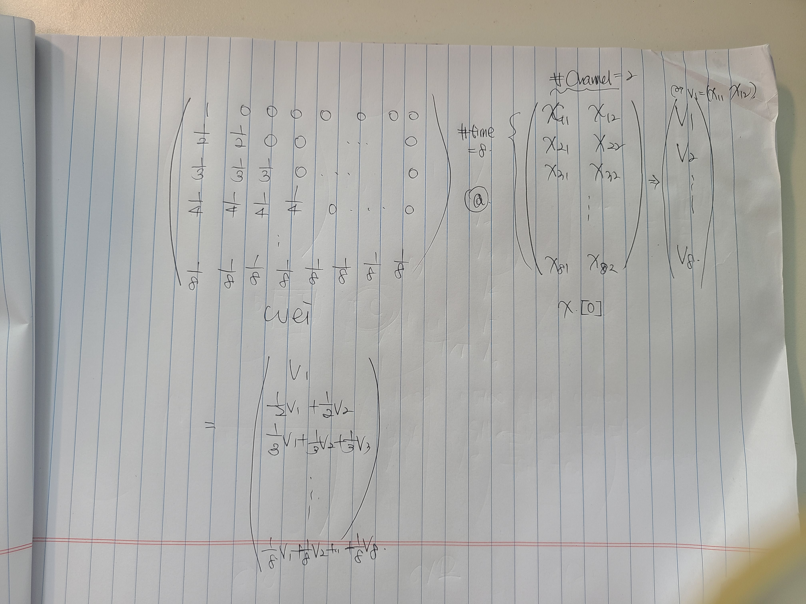

In [107]:
pip install pillow
from PIL import Image as PILImage

# 이미지 열기
img_path = r"C:\Users\haeri\Desktop\vscode\GPT_scratch\weighted sum.jpg"
img = PILImage.open(img_path)

# 이미지를 왼쪽으로 90도 회전
img_rotated = img

# 이미지를 50% 크기로 조정
width, height = img_rotated.size
new_size = (int(width *0.2), int(height *0.2))
img_resized = img_rotated.resize(new_size)
img_resized

In [112]:
# version 3: use Softmax -> 똑같은데 wei를 구하기 전까지 masked_fill과 softmax를 이용한 것이 차이

tril = torch.tril(torch.ones(T, T)) # 8*8
wei = torch.zeros((T,T)) # 8*8
wei = wei.masked_fill(tril == 0, float('-inf'))
print(wei)
wei = F.softmax(wei, dim=-1)
print(wei)

xbow3 = wei @ x
torch.allclose(xbow, xbow3, atol=1e-7)

tensor([[0., -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., 0., -inf, -inf, -inf],
        [0., 0., 0., 0., 0., 0., -inf, -inf],
        [0., 0., 0., 0., 0., 0., 0., -inf],
        [0., 0., 0., 0., 0., 0., 0., 0.]])
tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3333, 0.3333, 0.3333, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2500, 0.2500, 0.2500, 0.2500, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.0000, 0.0000, 0.0000],
        [0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.0000, 0.0000],
        [0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.0000],
        [0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250]])


True

In [145]:
# version 4: self-attention!

torch.manual_seed(1337)
B,T,C = 4,8,32 # batch, time, channels
x = torch.randn(B,T,C) # 4 * 8 * 32

# let's see a single Head perform self-attention
head_size = 16
key = nn.Linear(C, head_size, bias=False) # 32 * 16
query = nn.Linear(C, head_size, bias=False) # 32 * 16
value = nn.Linear(C, head_size, bias=False) # 32 * 16

k = key(x)   # (B, T, 32) -> (B, T, 16) 
q = query(x) # (B, T, 32) -> (B, T, 16)

wei =  q @ k.transpose(-2, -1) # 쿼리와 키의 내적을 통해 각 시점에 대한 중요도를 알아냄
# (B, T, 16) @ (B, 16, T) ---> (B, T, T) # k.transpose(-2,-1).shape # 끝에서 2번째 차원과 끝에서 1번째 차원을 교환

tril = torch.tril(torch.ones(T, T))
#wei = torch.zeros((T,T))

wei = wei.masked_fill(tril == 0, float('-inf'))
# print(wei) # 원래 wei에서 현재 시점 이후는 다 -inf로 변경
wei = F.softmax(wei, dim=-1)
print(wei) # 현재 시점 까지만 했을 때 쿼리와 키를 내적했을 때의 중요도를 계산
print('wei shape:', wei.shape) # 4 * 8 * 8

v = value(x) # (B, T, 32) -> (B, T, 16)
out = wei @ v # (B, T, T) @ (B, T, 16) -> (B, T, 16) # 각 배치 별 / 각 시점 (0~T까지) / 각각 16차원의 weighted sum된 value 값을 계산함
#out = wei @ x

tensor([[[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.1574, 0.8426, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.2088, 0.1646, 0.6266, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.5792, 0.1187, 0.1889, 0.1131, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0294, 0.1052, 0.0469, 0.0276, 0.7909, 0.0000, 0.0000, 0.0000],
         [0.0176, 0.2689, 0.0215, 0.0089, 0.6812, 0.0019, 0.0000, 0.0000],
         [0.1691, 0.4066, 0.0438, 0.0416, 0.1048, 0.2012, 0.0329, 0.0000],
         [0.0210, 0.0843, 0.0555, 0.2297, 0.0573, 0.0709, 0.2423, 0.2391]],

        [[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.1687, 0.8313, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.2477, 0.0514, 0.7008, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.4410, 0.0957, 0.3747, 0.0887, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0069, 0.0456, 0.0300, 0.7748, 0.1427, 0.0000, 0.0000, 0.0000],
         [0.0660, 0.089

In [141]:
print('out')
print(out)
print(out.shape)

out
tensor([[[-1.5713e-01,  8.8009e-01,  1.6152e-01, -7.8239e-01, -1.4289e-01,
           7.4676e-01,  1.0068e-01, -5.2395e-01, -8.8726e-01,  1.9068e-01,
           1.7616e-01, -5.9426e-01, -4.8124e-01, -4.8598e-01,  2.8623e-01,
           5.7099e-01],
         [ 6.7643e-01, -5.4770e-01, -2.4780e-01,  3.1430e-01, -1.2799e-01,
          -2.9521e-01, -4.2962e-01, -1.0891e-01, -4.9282e-02,  7.2679e-01,
           7.1296e-01, -1.1639e-01,  3.2665e-01,  3.4315e-01, -7.0975e-02,
           1.2716e+00],
         [ 4.8227e-01, -1.0688e-01, -4.0555e-01,  1.7696e-01,  1.5811e-01,
          -1.6967e-01,  1.6217e-02,  2.1509e-02, -2.4903e-01, -3.7725e-01,
           2.7867e-01,  1.6295e-01, -2.8951e-01, -6.7610e-02, -1.4162e-01,
           1.2194e+00],
         [ 1.9708e-01,  2.8561e-01, -1.3028e-01, -2.6552e-01,  6.6781e-02,
           1.9535e-01,  2.8073e-02, -2.4511e-01, -4.6466e-01,  6.9287e-02,
           1.5284e-01, -2.0324e-01, -2.4789e-01, -1.6213e-01,  1.9474e-01,
           7.6778e-01],


In [142]:
print('wei[0]') # 8 * 8
print(wei[0])

print('v[0]') # 8 * 16
print(v[0])

print('wei[0] @ v[0]') # (8*8) @ (8*16) = (8*16)

wei[0]
tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.1574, 0.8426, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2088, 0.1646, 0.6266, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5792, 0.1187, 0.1889, 0.1131, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0294, 0.1052, 0.0469, 0.0276, 0.7909, 0.0000, 0.0000, 0.0000],
        [0.0176, 0.2689, 0.0215, 0.0089, 0.6812, 0.0019, 0.0000, 0.0000],
        [0.1691, 0.4066, 0.0438, 0.0416, 0.1048, 0.2012, 0.0329, 0.0000],
        [0.0210, 0.0843, 0.0555, 0.2297, 0.0573, 0.0709, 0.2423, 0.2391]],
       grad_fn=<SelectBackward0>)
v[0]
tensor([[-0.1571,  0.8801,  0.1615, -0.7824, -0.1429,  0.7468,  0.1007, -0.5239,
         -0.8873,  0.1907,  0.1762, -0.5943, -0.4812, -0.4860,  0.2862,  0.5710],
        [ 0.8321, -0.8144, -0.3242,  0.5191, -0.1252, -0.4898, -0.5287, -0.0314,
          0.1072,  0.8269,  0.8132, -0.0271,  0.4775,  0.4980, -0.1377,  1.4025],
        [ 0.6035, -0.2500, -0.6159,

In [138]:
print('wei[0] @ v[0]')
print(wei[0] @ v[0])

wei[0] @ v[0]
tensor([[-0.1571,  0.8801,  0.1615, -0.7824, -0.1429,  0.7468,  0.1007, -0.5239,
         -0.8873,  0.1907,  0.1762, -0.5943, -0.4812, -0.4860,  0.2862,  0.5710],
        [ 0.6764, -0.5477, -0.2478,  0.3143, -0.1280, -0.2952, -0.4296, -0.1089,
         -0.0493,  0.7268,  0.7130, -0.1164,  0.3266,  0.3431, -0.0710,  1.2716],
        [ 0.4823, -0.1069, -0.4055,  0.1770,  0.1581, -0.1697,  0.0162,  0.0215,
         -0.2490, -0.3773,  0.2787,  0.1629, -0.2895, -0.0676, -0.1416,  1.2194],
        [ 0.1971,  0.2856, -0.1303, -0.2655,  0.0668,  0.1954,  0.0281, -0.2451,
         -0.4647,  0.0693,  0.1528, -0.2032, -0.2479, -0.1621,  0.1947,  0.7678],
        [ 0.2510,  0.7346,  0.5939,  0.2516,  0.2606,  0.7582,  0.5595,  0.3539,
         -0.5934, -1.0807, -0.3111, -0.2781, -0.9054,  0.1318, -0.1382,  0.6371],
        [ 0.3428,  0.4960,  0.4725,  0.3028,  0.1844,  0.5814,  0.3824,  0.2952,
         -0.4897, -0.7705, -0.1172, -0.2541, -0.6892,  0.1979, -0.1513,  0.7666],
        

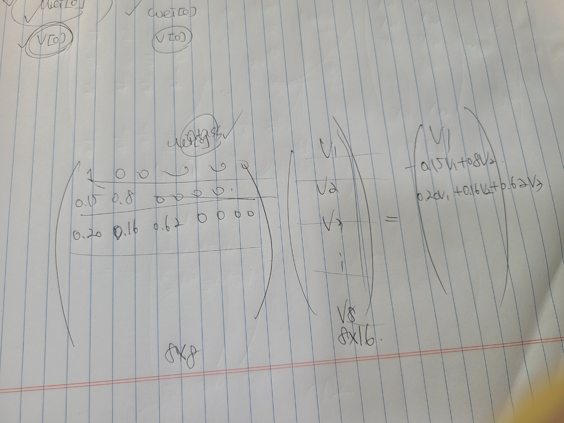

In [144]:
from PIL import Image as PILImage

# 이미지 열기
img_path = r"C:\Users\haeri\Desktop\vscode\GPT_scratch\weighted sum2.jpg"
img = PILImage.open(img_path)

# 이미지를 왼쪽으로 90도 회전
img_rotated = img

# 이미지를 50% 크기로 조정
width, height = img_rotated.size
new_size = (int(width *0.4), int(height *0.4))
img_resized = img_rotated.resize(new_size)
img_resized

Attention은 "communication mechanmism"이다
- 이는 data-dependent한 가중치를 사용하여 자신을 가리키는 모든 노드들의 가중치 합계로 정보를 집계하는 방향성 그래프 안에서의 노드로 비춰질 수 있다!
- 자신을 가리키는 모든 노드들 =block size 내 자신보다 이전 시점의 토큰들

- 공간(=시간/순서 정보)에 대한 개념은 없으며, attention은 vector에 대해 작용한다. 따라서 토큰을 위치적으로(positionally) 인코딩해야 하는 이유이다.
- 배치 차원의 각 예는 완전히 독립적으로(independently) 처리되며, 서로 절대 "대화(talk)"하지 않음
- "인코더" 어텐션 블록에서 "tril"로 마스킹하는 단일 라인을 삭제하면, 모든 토큰들이 서로 communicate한다. 여기서 이 블록은 삼각형(triangular) 마스킹을 가지고 있어, 디코더 어텐션 블록이라 하며 일반적으로 language modeling과 같은 autogressive setting에 주로 사용된다.
- "self-attnetion"의 뜻은 "keys"와 "values"가 "queries"와 동일한 source에서 생성된다는 의미이다.
- "cross-attnetion"의 경우에는, 여전히 queries는 x에서 생성되지만, "keys"와 "values"는 외부의 source(=인코더 모듈을 통해 도출된 컨텍스트 벡터)로부터 온다
- "Scaled" 어텐션 추가는 wei를 1 / sqrt(head_size)로 나눈다. 이로 인해 input Q, K 가 unit variance일 때, wei 또한 unit variance 가 되며 softmax는 diffuse 상태를 유지하고 너무 많이 saturate 되지 않는다 (??)

In [148]:
head_size

16

In [168]:
import math
k = torch.randn(B,T,head_size) # torch.randn이 평균 0, 분산 1인 정규분포에서 랜덤 샘플링 한거니까 분산이 당연히 1에 가깝게 나온다.
q = torch.randn(B,T,head_size)  

wei = q @ k.transpose(-2, -1) * head_size**-0.5 
# wei = q @ k.transpose(-2, -1) / math.sqrt(head_size) # 위와 동일한 코드

In [172]:
k.var(), q.var(), (q @ k.transpose(-2,-1)).var(), wei.var()
# 즉 math.sqrt(head_size) 로 나누지 않으면 분산이 head_size와 비슷

(tensor(1.0104), tensor(1.0204), tensor(17.6841), tensor(1.1053))

In [175]:
print(torch.softmax(torch.tensor([0.1, -0.2, 0.3, -0.2, 0.5]), dim=-1))
print(torch.softmax(torch.tensor([0.1, -0.2, 0.3, -0.2, 0.5])*8, dim=-1)) # 값이 너무 차이가 커지면, 원핫 벡터로 수렴하게 되는 문제가 발생할 수도 있다는 뜻인 듯. gets too peaky, converges to one-hot

tensor([0.1925, 0.1426, 0.2351, 0.1426, 0.2872])
tensor([0.0326, 0.0030, 0.1615, 0.0030, 0.8000])


In [184]:
class LayerNorm1d: # (used to be BatchNorm1d) 
    # 1차원의 입력을 정규화하는 방법. 배치 정규화와 유사하지만 배치에 대한 평균과 분산 대신 레이어의 입력에 대한 평균과 분산을 사용한다(?)

  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps
    self.gamma = torch.ones(dim) # gamma: 100차원 벡터. beta는 정규화된 입력에 적용되는 스케일 조정 및 이동 매개변수, 핫학습 가능한 파라미터
    self.beta = torch.zeros(dim) # beta: 100차원 벡터.

  def __call__(self, x): 
    # __call__은 객체를 함수처럼 호출할 때, 호출되는 특수한 메서드. 해당 메서드를 정의하면 객체를 함수처럼 호출할 수 있음
    # forward랑 정확히 동일한데 forward는 torch.nn.Module을 상속한 클래스에서 정의할 수 있음

    # calculate the forward pass
    xmean = x.mean(dim=1, keepdim=True) # batch mean 
    print(xmean.shape) # 각 배치 별 평균
    xvar = x.var(dim=1, keepdim=True) # batch variance # 배치 별 분산
     
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance # xhat은 평균이 0이고 분산이 1인 표준화된 입력
    print(xhat.shape)
    self.out = self.gamma * xhat + self.beta # 정규화된 gamma: 입력의 스케일을 조정. 입력의 각 차원의 중요도를 조절 / beta: offset 매개변수. 입력 데이터의 분포를 이동시킴

    return self.out

  def parameters(self):
    return [self.gamma, self.beta]

torch.manual_seed(1337)
module = LayerNorm1d(100)
x = torch.randn(32, 100) # batch size 32 of 100-dimensional vectors
x = module(x)
x.shape

torch.Size([32, 1])
torch.Size([32, 100])


torch.Size([32, 100])

In [188]:
print(x[:,0].mean(), x[:,0].std()) # mean,std of one feature across all batch inputs -> 0번째 feature에 대한 배치를 모두 계산했을 때 중요도의 평균과 분산
print(x[0,:].mean(), x[0,:].std()) # mean,std of a single input from the batch, of its features -> 0번째 배치에 대해 100개의 feature에 대한 평균과 분산: 평균 0, 분산 1

tensor(0.1469) tensor(0.8803)
tensor(-9.5367e-09) tensor(1.0000)


In [189]:
# French to English translation example:

# <--------- ENCODE ------------------><--------------- DECODE ----------------->
# les réseaux de neurones sont géniaux! <START> neural networks are awesome!<END>

Full finish code! You may want to refer directly to the git repo instead though.

In [190]:
import torch
import torch.nn as nn
from torch.nn import functional as F

# hyperparameters
batch_size = 16 # how many independent sequences will we process in parallel?
block_size = 32 # what is the maximum context length for predictions?
max_iters = 5000
eval_interval = 100
learning_rate = 1e-3
device = 'cuda' if torch.cuda.is_available() else 'cpu'
eval_iters = 200
n_embd = 64
n_head = 4
n_layer = 4
dropout = 0.0
# ------------

In [191]:
torch.manual_seed(1337)
with open('input.txt', 'r', encoding='utf-8') as f:
    text = f.read()

chars = sorted(list(set(text)))
vocab_size = len(chars)
stoi = { ch:i for i,ch in enumerate(chars) }
itos = { i:ch for i,ch in enumerate(chars) }
encode = lambda s: [stoi[c] for c in s] # encoder: take a string, output a list of integers
decode = lambda l: ''.join([itos[i] for i in l]) # decoder: take a list of integers, output a string

# Train and test splits
data = torch.tensor(encode(text), dtype=torch.long)
n = int(0.9*len(data)) # first 90% will be train, rest val
train_data = data[:n]
val_data = data[n:]

In [192]:
# data loading
def get_batch(split):
    # generate a small batch of data of inputs x and targets y
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    x, y = x.to(device), y.to(device)
    return x, y

In [ ]:
@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters) # 200
        for k in range(eval_iters): # 200
            X, Y = get_batch(split) # 200번 16개씩 배치를 가져옴
            logits, loss = model(X, Y) # X, Y를 model에 집어넣어서 logits와 loss를 뽑아
            losses[k] = loss.item() # k번째 iter에 loss를 저장
        out[split] = losses.mean()
    model.train()
    return out

In [193]:
class Head(nn.Module):
    """ one head of self-attention """

    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size))) # Pytorch 모듈 안에 상수나 고정된 값을 사용하는 데 사용됨. 
        # triangular mask 행렬을 생성한 후, 버퍼에 등록함. self.tril을 통해 해당 행렬을 참조할 수 있고 모델의 가중치로 취급되지 않고 고정됨 (효율적인 메모리 관리와 모델 파라미터와 상관 없는 상수나 고정된 값을 이용할 때)

        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        B,T,C = x.shape
        k = self.key(x)   # (B,T,C) = batch * timte * channel
        q = self.query(x) # (B,T,C)
        # compute attention scores ("affinities")
        wei = q @ k.transpose(-2,-1) * C**-0.5 # (B, T, C) @ (B, C, T) -> (B, T, T)

        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf')) # (B, T, T)
        wei = F.softmax(wei, dim=-1) # (B, T, T)
        wei = self.dropout(wei)

        # perform the weighted aggregation of the values
        v = self.value(x) # (B,T,C)
        out = wei @ v # (B, T, T) @ (B, T, C) -> (B, T, C)
        return out

In [194]:
class MultiHeadAttention(nn.Module):
    """ multiple heads of self-attention in parallel """
    
    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
        self.proj = nn.Linear(n_embd, n_embd)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.dropout(self.proj(out))
        return out

In [195]:
class FeedFoward(nn.Module): #  a simple linear layer followed by a non-linearity 

    def __init__(self, n_embd):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.ReLU(),
            nn.Linear(4 * n_embd, n_embd),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        return self.net(x)

In [196]:
class Block(nn.Module):
    """ Transformer block: communication followed by computation """

    def __init__(self, n_embd, n_head):
        # n_embd: embedding dimension, n_head: the number of heads we'd like
        super().__init__()
        head_size = n_embd // n_head
        self.sa = MultiHeadAttention(n_head, head_size)
        self.ffwd = FeedFoward(n_embd)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)

    def forward(self, x): # residual connection
        x = x + self.sa(self.ln1(x))
        x = x + self.ffwd(self.ln2(x))
        return x

In [197]:
# super simple bigram model
class BigramLanguageModel(nn.Module):

    def __init__(self):
        super().__init__()
        # each token directly reads off the logits for the next token from a lookup table
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        self.position_embedding_table = nn.Embedding(block_size, n_embd)
        self.blocks = nn.Sequential(*[Block(n_embd, n_head=n_head) for _ in range(n_layer)])
        self.ln_f = nn.LayerNorm(n_embd) # final layer norm
        self.lm_head = nn.Linear(n_embd, vocab_size)

    def forward(self, idx, targets=None):
        B, T = idx.shape

        # idx and targets are both (B,T) tensor of integers
        tok_emb = self.token_embedding_table(idx) # (B,T,C)
        pos_emb = self.position_embedding_table(torch.arange(T, device=device)) # (T,C)
        x = tok_emb + pos_emb # (B,T,C)
        x = self.blocks(x) # (B,T,C)
        x = self.ln_f(x) # (B,T,C)
        logits = self.lm_head(x) # (B,T,vocab_size)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    def generate(self, idx, max_new_tokens):
        # idx is (B, T) array of indices in the current context
        for _ in range(max_new_tokens):
            # crop idx to the last block_size tokens
            idx_cond = idx[:, -block_size:]
            # get the predictions
            logits, loss = self(idx_cond)
            # focus only on the last time step
            logits = logits[:, -1, :] # becomes (B, C)
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) # (B, C)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            # append sampled index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
        return idx

In [198]:
model = BigramLanguageModel()
m = model.to(device)
# print the number of parameters in the model
print(sum(p.numel() for p in m.parameters())/1e6, 'M parameters')

# create a PyTorch optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

for iter in range(max_iters):
    # every once in a while evaluate the loss on train and val sets
    if iter % eval_interval == 0 or iter == max_iters - 1:
        losses = estimate_loss()
        print(f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")

    # sample a batch of data
    xb, yb = get_batch('train')

    # evaluate the loss
    logits, loss = model(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

# generate from the model
context = torch.zeros((1, 1), dtype=torch.long, device=device)
print(decode(m.generate(context, max_new_tokens=2000)[0].tolist()))

0.209729 M parameters
step 0: train loss 4.4116, val loss 4.4022
step 100: train loss 2.6567, val loss 2.6669
step 200: train loss 2.5090, val loss 2.5058
step 300: train loss 2.4193, val loss 2.4333
step 400: train loss 2.3504, val loss 2.3565
step 500: train loss 2.2966, val loss 2.3136
step 600: train loss 2.2410, val loss 2.2502
step 700: train loss 2.2052, val loss 2.2186
step 800: train loss 2.1642, val loss 2.1875
step 900: train loss 2.1244, val loss 2.1507
step 1000: train loss 2.1026, val loss 2.1298
step 1100: train loss 2.0688, val loss 2.1171
step 1200: train loss 2.0383, val loss 2.0805
step 1300: train loss 2.0248, val loss 2.0638
step 1400: train loss 1.9913, val loss 2.0356
step 1500: train loss 1.9693, val loss 2.0295
step 1600: train loss 1.9636, val loss 2.0486
step 1700: train loss 1.9412, val loss 2.0131
step 1800: train loss 1.9088, val loss 1.9952
step 1900: train loss 1.9100, val loss 1.9887
step 2000: train loss 1.8837, val loss 1.9948
step 2100: train loss 1.